In [1]:
# imports
from sklearn.model_selection import train_test_split
from moduleDatabase import DatabaseMethods
from moduleUtilities import UtilityMethods
from modulePreProcessing import TransformationMethods, FeatureMethods
from moduleModelTraining import TrainingMethods
from moduleMetrics import MetricsMethods

In [2]:
# class instances
db = DatabaseMethods()
ut = UtilityMethods()
tf = TransformationMethods()
fm = FeatureMethods()
train = TrainingMethods()
evaluate = MetricsMethods()

In [3]:
# connect to db and fetch data
df = db.fetch("SELECT * FROM v8")
df.head()

,userId,gsId,gsStartTime,age,sex,education,laptop_usage,smartphone_usage,smoking,family_med_history,...,mmse_pre_binary_binned,moca_pre_init,moca_pre_severity_binned,moca_pre_binary_binned,mmse_post_init,mmse_post_severity_binned,mmse_post_binary_binned,moca_post_init,moca_post_severity_binned,moca_post_binary_binned
0,23,18245,1560929400,70,1,4,0,0,0,1,...,1,19,2,1,21,2,1,23,2,1
1,6,76067,1555499640,61,1,4,1,3,0,1,...,2,24,2,1,29,3,2,26,3,2
2,8,79781,1557928260,83,1,5,1,1,0,0,...,2,25,2,1,25,3,2,22,2,1
3,32,180144,1557315840,71,1,2,0,4,0,0,...,2,27,3,2,29,3,2,25,2,1
4,24,209758,1560933840,75,1,2,0,0,0,1,...,1,21,2,1,18,2,1,19,2,1


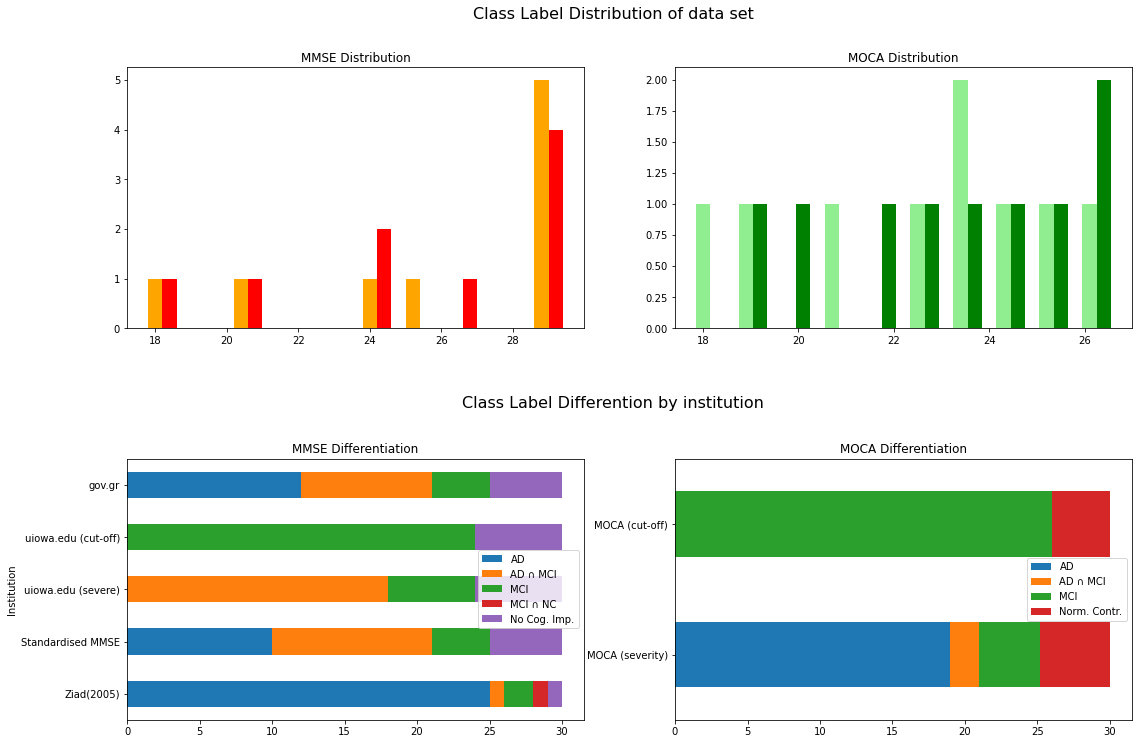

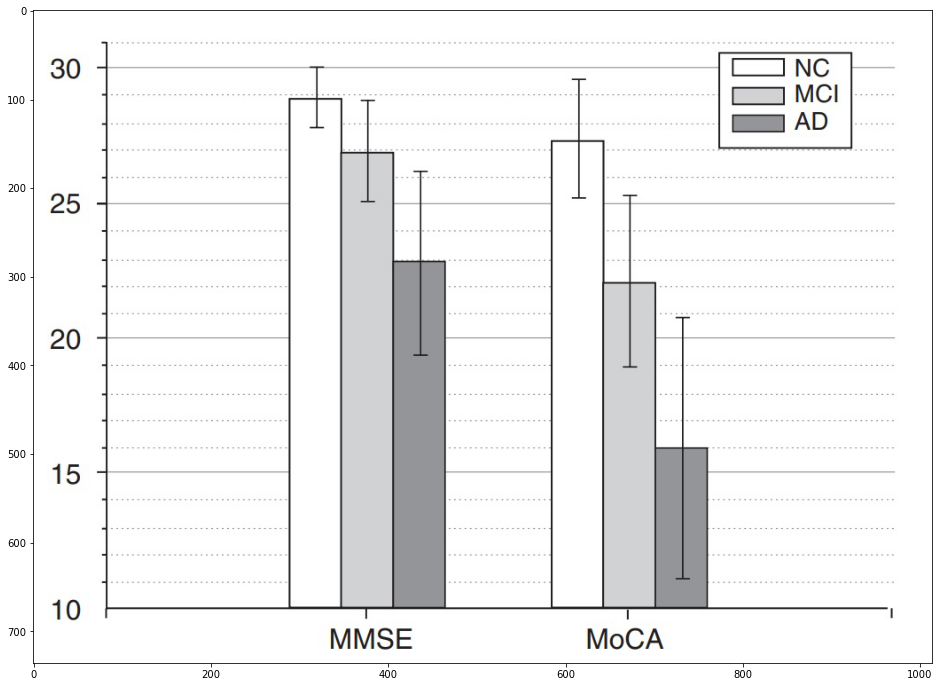

In [4]:
# inspect the distribution of potential target classes
ut.inspect_target_distribution(df)

In [5]:
# define target class (14 available, 6 moca, 6 mmse, 2 diffs)
df = db.separate_target_class(df, "moca_pre_binary_binned")

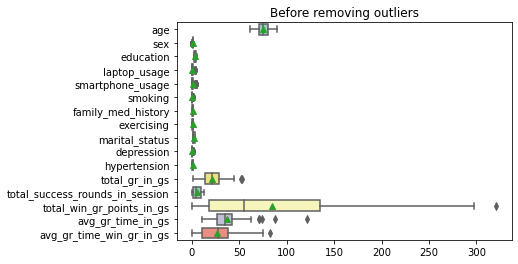

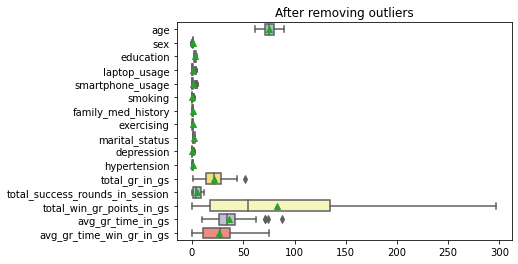

In [6]:
# handling outliers. ignoring outliers for user data.
# The whole process should avoid outliers in the first place.
df = tf.handle_outliers(df)

In [7]:
# Encoding of categorical to numerical.
columns_to_one_hot_encode = ('marital_status')
df = fm.one_hot_encode_features(df, columns_to_one_hot_encode)

df shape before drop: (119, 20)
df shape after drop, before ohe: (119, 19)
df shape after ohe: (119, 21)


In [8]:
# Discretize 1) to calculate variance in same scale 2) because I need to convert any feature of float type to int early.
columns_to_discretize = ['age','avg_gr_time_win_gr_in_gs', 'avg_gr_time_win_gr_in_gs', 'avg_gr_time_in_gs', 
                         'total_win_gr_points_in_gs', 'total_gr_in_gs', 'total_success_rounds_in_session']
fm.discretize_features(df, columns_to_discretize)

,userId,gsId,gsStartTime,age,sex,education,laptop_usage,smartphone_usage,smoking,family_med_history,...,depression,hypertension,total_gr_in_gs,total_success_rounds_in_session,total_win_gr_points_in_gs,avg_gr_time_in_gs,avg_gr_time_win_gr_in_gs,target_class,marital_status_1,marital_status_3
gsId,,,,,,,,,,,,,,,,,,,,,
18245,23,18245,1560929400,1,1,4,0,0,0,1,...,0,0,0,1,2,0,2,1,1.0,0.0
76067,6,76067,1555499640,0,1,4,1,3,0,1,...,0,1,5,3,3,4,5,1,0.0,1.0
79781,8,79781,1557928260,5,1,5,1,1,0,0,...,0,0,1,3,1,4,5,1,1.0,0.0
180144,32,180144,1557315840,2,1,2,0,4,0,0,...,0,1,5,1,2,3,1,2,1.0,0.0
209758,24,209758,1560933840,3,1,2,0,0,0,1,...,0,1,3,1,1,2,1,1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5654576,8,5654576,1558894440,5,1,5,1,1,0,0,...,0,0,5,4,5,1,4,1,1.0,0.0
5723404,4,5723404,1556711460,5,1,3,3,0,0,0,...,0,0,5,5,5,3,4,1,0.0,1.0
5751092,7,5751092,1560012840,4,0,4,0,0,0,0,...,1,1,5,5,5,4,4,1,1.0,0.0


,0
total_success_rounds_in_session,3.13
total_gr_in_gs,2.97
avg_gr_time_win_gr_in_gs,2.96
avg_gr_time_in_gs,2.96
total_win_gr_points_in_gs,2.93
age,2.47
smartphone_usage,2.28
education,1.06
laptop_usage,0.86
family_med_history,0.25


Threshold value:  0.16
Features ruled out: 
 ['sex', 'smoking', 'depression']


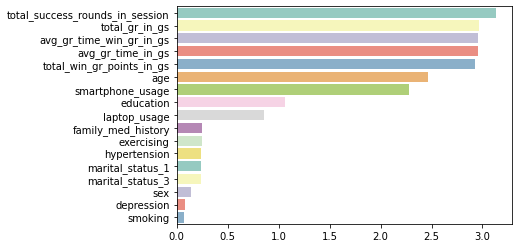

In [9]:
# remove low variance features. VarX = p(1-p). Where p is the probability of a value of a feature.
df = fm.remove_low_variance_features(df, (.8 * (1 - .8)), ddof_val=1)

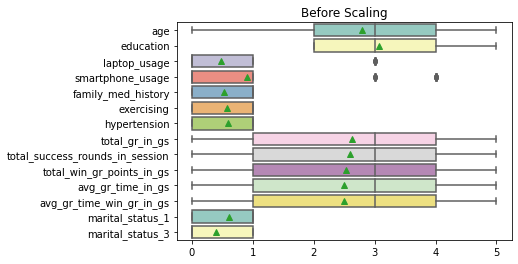

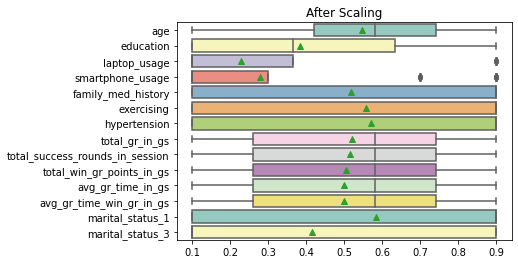

In [10]:
# scaling
# TODO try to use StandardScaler for user data.
columnsToIgnore = ['userId', 'gsId', 'gsStartTime', 'target_class']
df = tf.use_min_max(df, columnsToIgnore)

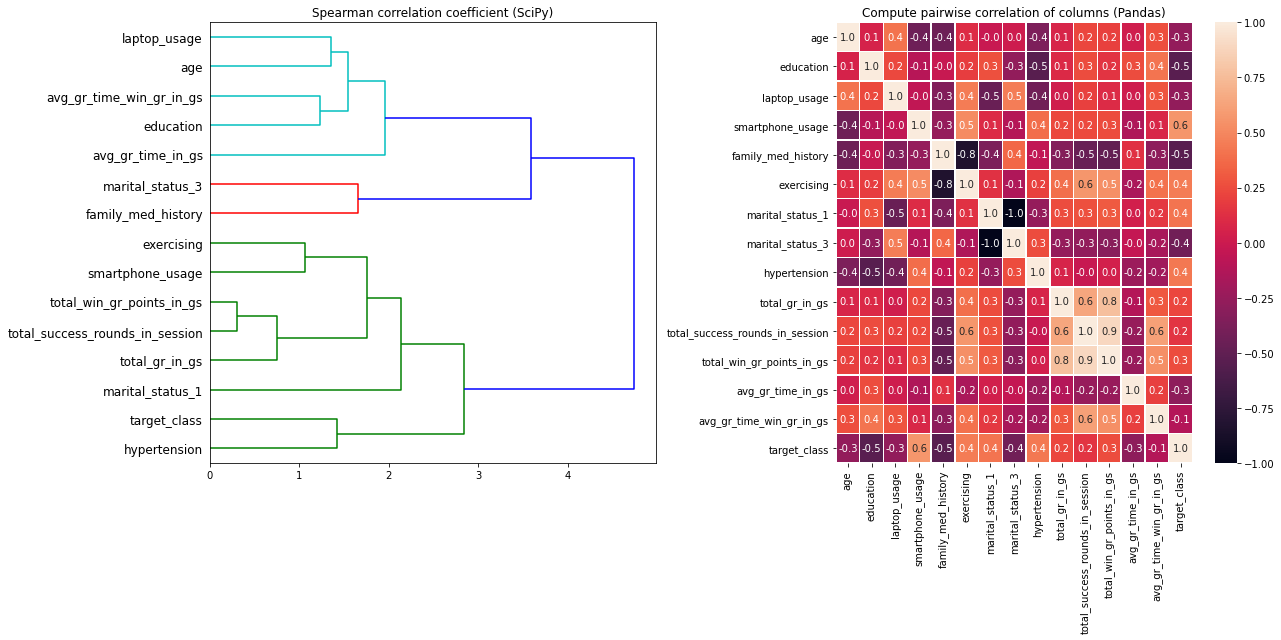

In [11]:
# feature correlation inspection. Select features correlated to target class not between them.
fs = ['age', 'education','laptop_usage', 'smartphone_usage', 'family_med_history', 'exercising', 'marital_status_1',
      'marital_status_3', 'hypertension', 'total_gr_in_gs', 'total_success_rounds_in_session', 'total_win_gr_points_in_gs', 
      'avg_gr_time_in_gs', 'avg_gr_time_win_gr_in_gs', 'target_class']
fm.correlation_inspection(df, fs)

In [12]:
all_features = ['age', 'education','laptop_usage', 'smartphone_usage', 'family_med_history', 'exercising',
                'marital_status_1', 'marital_status_3', 'hypertension', 
                'total_gr_in_gs', 'total_success_rounds_in_session', 'total_win_gr_points_in_gs', 
                'avg_gr_time_in_gs', 'avg_gr_time_win_gr_in_gs']
cl1_features = ['laptop_usage', 'age', 'avg_gr_time_win_gr_in_gs', 'education', 'avg_gr_time_in_gs']
cl2_features = ['marital_status_3', 'family_med_history']
cl3_features = ['exercising', 'smartphone_usage', 'total_win_gr_points_in_gs', 'total_success_rounds_in_session',
                'total_gr_in_gs', 'marital_status_1', 'hypertension']
session_features = ['total_gr_in_gs', 'total_success_rounds_in_session', 'total_win_gr_points_in_gs', 
                    'avg_gr_time_in_gs', 'avg_gr_time_win_gr_in_gs']

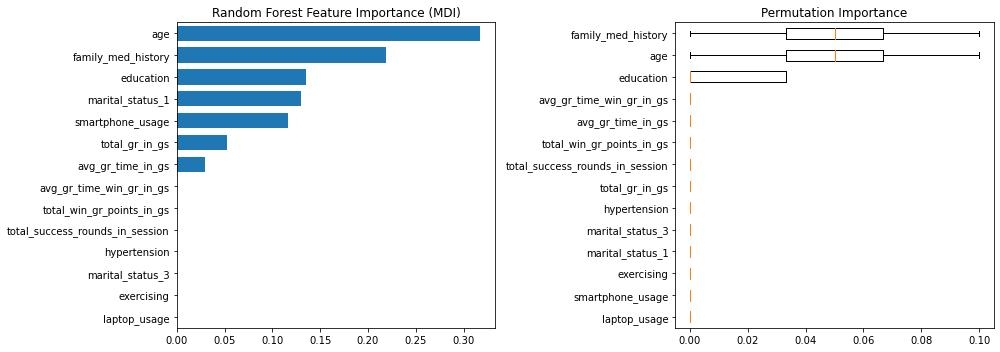

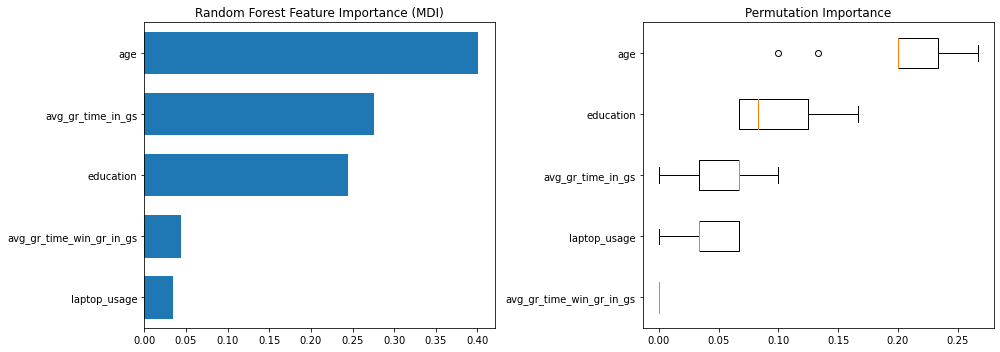

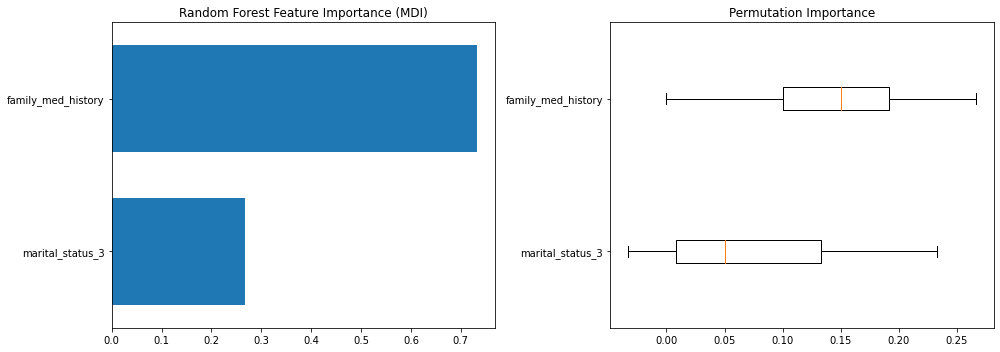

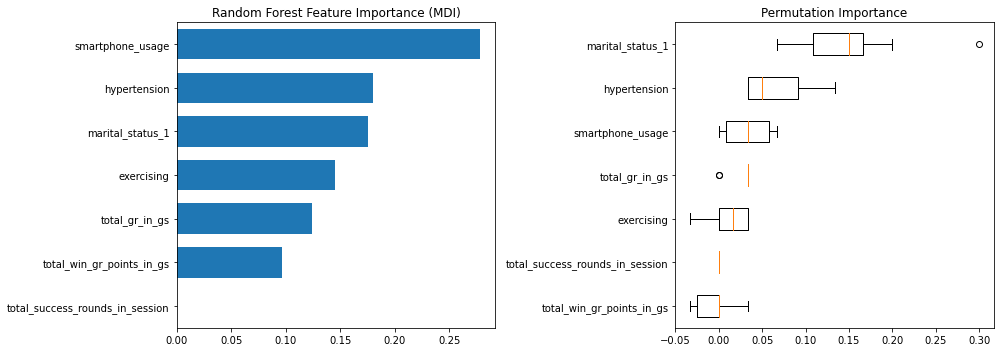

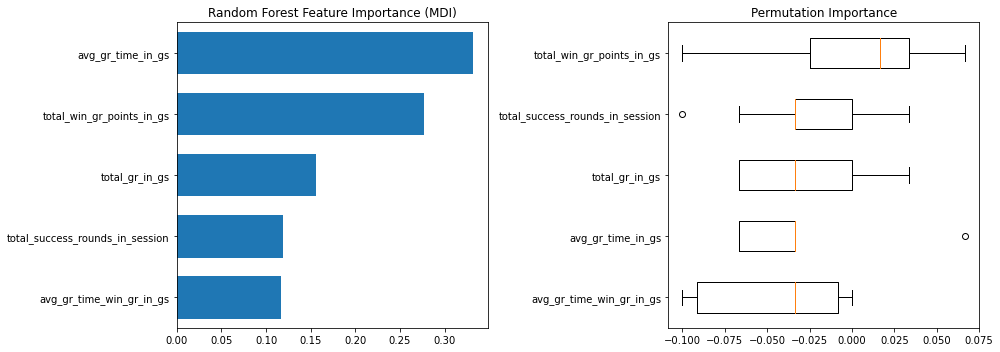

In [13]:
# feature importance inspection using a classifier
# MDI feature importance and feature values permutation importance

fm.inspection_using_classifier(df, all_features)
fm.inspection_using_classifier(df, cl1_features)
fm.inspection_using_classifier(df, cl2_features)
fm.inspection_using_classifier(df, cl3_features)
fm.inspection_using_classifier(df, session_features)

<Figure size 432x288 with 0 Axes>

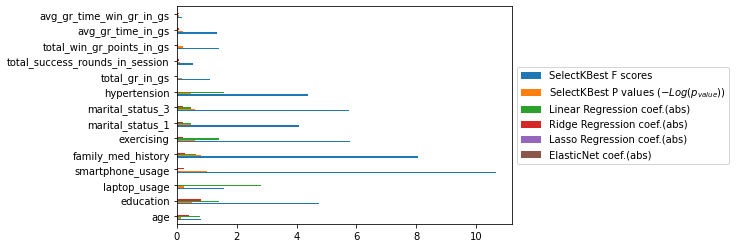

<Figure size 432x288 with 0 Axes>

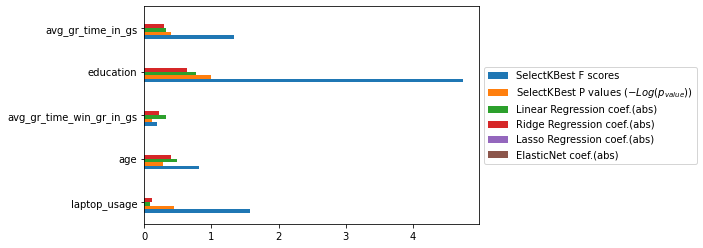

<Figure size 432x288 with 0 Axes>

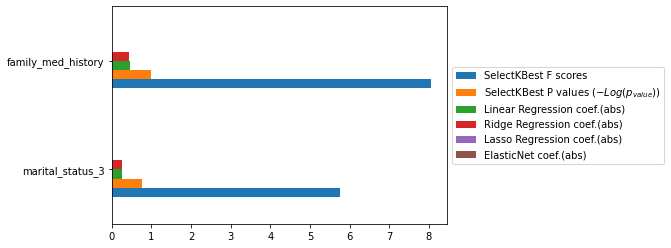

<Figure size 432x288 with 0 Axes>

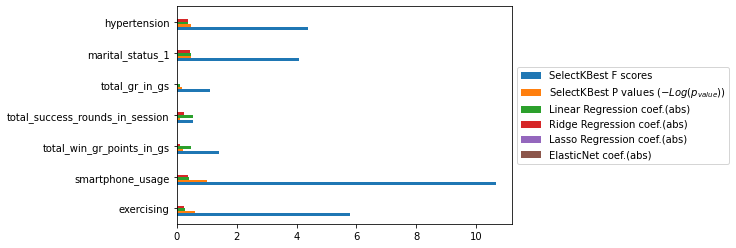

<Figure size 432x288 with 0 Axes>

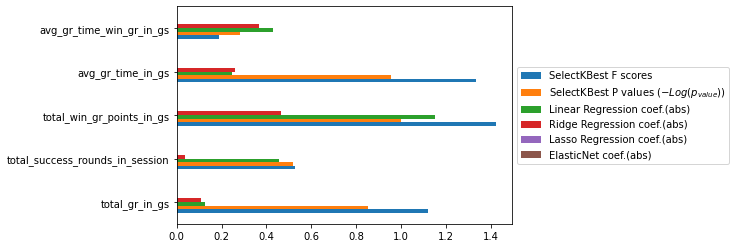

In [14]:
# Feature importance inspection using Univariate Feature Selection
# More specifically, ANOVA and some traditional Regressors
# TODO check also for the target as continuous  

fm.inspection_using_regressors(df, all_features)
fm.inspection_using_regressors(df, cl1_features)
fm.inspection_using_regressors(df, cl2_features)
fm.inspection_using_regressors(df, cl3_features)
fm.inspection_using_regressors(df, session_features)

In [15]:
test_size = 0.25
cross_val_num=3

In [16]:
# split dataframe samples for the training and evaluation process
selected_features = ['education', 'avg_gr_time_in_gs',
                     'family_med_history',
                     'total_gr_in_gs']
x = df[selected_features]
y = df.iloc[:, df.columns.get_loc('target_class')]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=7, test_size=test_size)
print('x:',x.shape,' y:',y.shape)
print('x_train:',x_train.shape,' x_test:',x_test.shape,' y_train:',y_train.shape,'y_test:',y_train.shape)

x: (119, 4)  y: (119,)
x_train: (89, 4)  x_test: (30, 4)  y_train: (89,) y_test: (89,)


In [17]:
# train models before oversampling
trained_models = train.train_models(x_train, y_train, x_test, y_test)

trained model:  lr  accuracy:  80.00000000000001
trained model:  dt  accuracy:  96.66666666666667
trained model:  rf  accuracy:  93.33333333333333
trained model:  sv  accuracy:  80.00000000000001
trained model:  kn  accuracy:  96.66666666666667
trained model:  ce  accuracy:  100.0
Total training time: 0.17 seconds


Metrics for  Logistic Regression
accuracy  Score: 80.000% Std.: 0.000%
precision  Score: 80.000% Std.: 0.000%
recall  Score: 100.000% Std.: 0.000%
f1  Score: 88.889% Std.: 0.000%
Specificity: 1.0
############## 

<class 'sklearn.metrics._plot.roc_curve.RocCurveDisplay'>
Metrics for  Decision Tree
accuracy  Score: 100.000% Std.: 0.000%
precision  Score: 100.000% Std.: 0.000%
recall  Score: 100.000% Std.: 0.000%
f1  Score: 97.778% Std.: 3.143%
Specificity: 1.0
############## 

Metrics for  Random Forest
accuracy  Score: 93.333% Std.: 9.428%
precision  Score: 93.333% Std.: 9.428%
recall  Score: 100.000% Std.: 0.000%
f1  Score: 96.296% Std.: 5.238%
Specificity: 1.0
############## 

Metrics for  Support Vector Classifier
accuracy  Score: 80.000% Std.: 0.000%
precision  Score: 80.000% Std.: 0.000%
recall  Score: 100.000% Std.: 0.000%
f1  Score: 88.889% Std.: 0.000%
Specificity: 1.0
############## 

Metrics for  K Neighbors Classifier
accuracy  Score: 96.667% Std.: 4.714%
precision  Score: 10

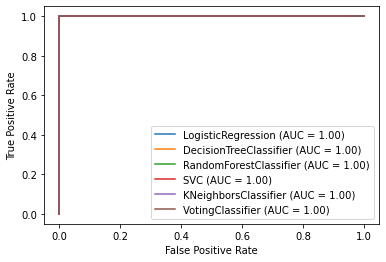

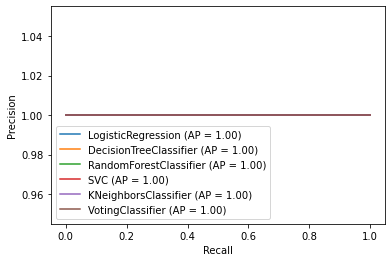

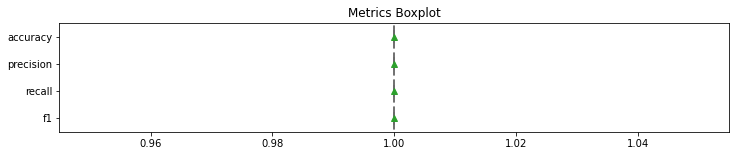

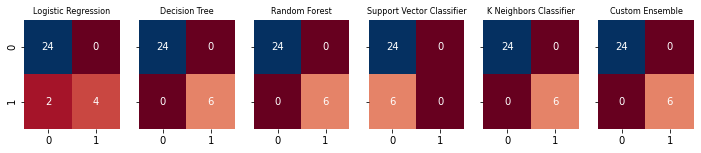

In [18]:
# evaluate models before oversampling
evaluate.generate_metrics(trained_models, x_test, y_test, ['accuracy', 'precision', 'recall', 'f1'], 
                          cv_num=cross_val_num, show_raw_data=False)

In [19]:
# apply oversampling 
from imblearn.over_sampling import SMOTE
print("Before SMOTE OverSampling. NC: {}".format(sum(y_train==2)))
print("Before SMOTE OverSampling. AD-MCI: {} \n".format(sum(y_train==1)))

smote_tf = SMOTE(random_state=2)
smote_x, smote_y = smote_tf.fit_sample(x_train, y_train.ravel())
smote_train_x, smote_test_x, smote_train_y, smote_test_y = train_test_split(smote_x, smote_y, random_state=7, test_size=test_size)

print('smote_x:',smote_x.shape,' smote_y:',smote_y.shape)
print('smote_train_x:',smote_train_x.shape,' smote_test_x:',smote_test_x.shape,' smote_train_y:',smote_train_y.shape,' smote_test_y:',smote_test_y.shape, '\n')

print("Before SMOTE OverSampling. NC: {}".format(sum(smote_y==2)))
print("Before SMOTE OverSampling. AD-MCI: {} \n".format(sum(smote_y==1)))

Before SMOTE OverSampling. NC: 19
Before SMOTE OverSampling. AD-MCI: 70 

smote_x: (140, 4)  smote_y: (140,)
smote_train_x: (105, 4)  smote_test_x: (35, 4)  smote_train_y: (105,)  smote_test_y: (35,) 

Before SMOTE OverSampling. NC: 70
Before SMOTE OverSampling. AD-MCI: 70 



In [20]:
# train models after oversampling
trained_models_smote = train.train_models(smote_train_x, smote_train_y, smote_test_x, smote_test_y)

trained model:  lr  accuracy:  74.4949494949495
trained model:  dt  accuracy:  93.93939393939394
trained model:  rf  accuracy:  91.16161616161617
trained model:  sv  accuracy:  62.878787878787875
trained model:  kn  accuracy:  88.63636363636364
trained model:  ce  accuracy:  100.0
Total training time: 0.16 seconds


Metrics for  Logistic Regression
accuracy  Score: 74.495% Std.: 6.196%
precision  Score: 100.000% Std.: 0.000%
recall  Score: 31.667% Std.: 13.123%
f1  Score: 46.667% Std.: 14.402%
Specificity: 0.8461538461538461
############## 

<class 'sklearn.metrics._plot.roc_curve.RocCurveDisplay'>
Metrics for  Decision Tree
accuracy  Score: 100.000% Std.: 0.000%
precision  Score: 91.667% Std.: 11.785%
recall  Score: 91.667% Std.: 11.785%
f1  Score: 100.000% Std.: 0.000%
Specificity: 1.0
############## 

Metrics for  Random Forest
accuracy  Score: 91.162% Std.: 7.431%
precision  Score: 85.000% Std.: 10.801%
recall  Score: 91.667% Std.: 11.785%
f1  Score: 87.963% Std.: 10.227%
Specificity: 1.0
############## 

Metrics for  Support Vector Classifier
accuracy  Score: 62.879% Std.: 3.444%
precision  Score: 0.000% Std.: 0.000%
recall  Score: 0.000% Std.: 0.000%
f1  Score: 0.000% Std.: 0.000%
Specificity: 1.0
############## 

Metrics for  K Neighbors Classifier
accuracy  Score: 88.636% Std.: 3.763%
prec

C:\Users\christos\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\christos\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\christos\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy  Score: 93.939% Std.: 8.571%
precision  Score: 100.000% Std.: 0.000%
recall  Score: 100.000% Std.: 0.000%
f1  Score: 91.667% Std.: 11.785%
Specificity: 1.0
############## 



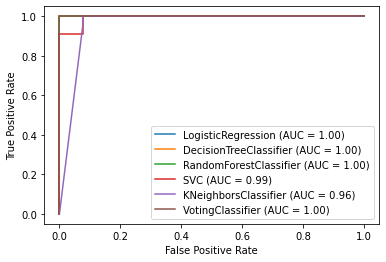

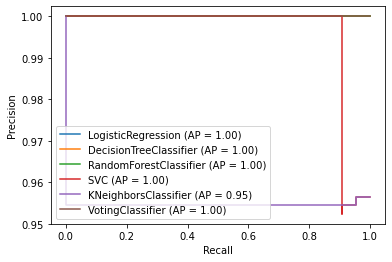

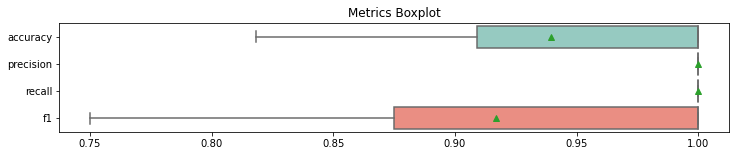

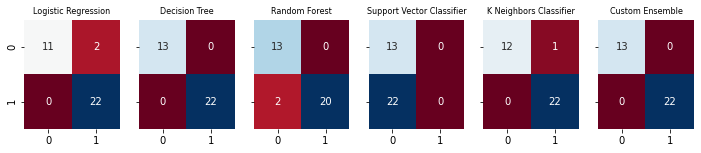

In [21]:
# evaluate models after sampling
evaluate.generate_metrics(trained_models_smote, smote_test_x, smote_test_y, ['accuracy', 'precision', 'recall', 'f1'], 
                          cv_num=cross_val_num, show_raw_data=False)

pca_x: (140, 2)
explained variance ratio (first two components): [0.53726014 0.18917404]


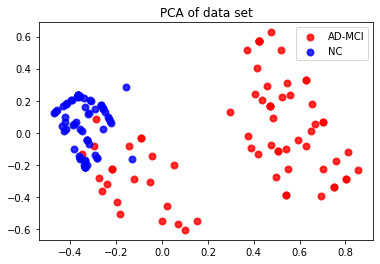

In [22]:
# apply dimensionality reduction using PCA
# example https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_x = pca.fit(smote_x).transform(smote_x)
print('pca_x:',pca_x.shape)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['red', 'blue']
lw = 2
for color, i, target_name in zip(colors, [1, 2], ['AD-MCI','NC']):
    plt.scatter(pca_x[smote_y == i, 0], pca_x[smote_y == i, 1], color=color, alpha=.8, lw=lw, label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of data set')
plt.show();

In [23]:
# split of pca_x and smote_y to train test data set
pca_train_x, pca_test_x, pca_train_y, pca_test_y = train_test_split(pca_x, smote_y, random_state=7, test_size=test_size)

trained model:  lr  accuracy:  74.4949494949495
trained model:  dt  accuracy:  100.0
trained model:  rf  accuracy:  91.16161616161617
trained model:  sv  accuracy:  62.878787878787875
trained model:  kn  accuracy:  88.63636363636364
trained model:  ce  accuracy:  93.93939393939394
Total training time: 0.21 seconds
Metrics for  Logistic Regression
accuracy  Score: 80.303% Std.: 7.500%
precision  Score: 100.000% Std.: 0.000%
recall  Score: 46.667% Std.: 20.950%
f1  Score: 60.952% Std.: 18.856%
Specificity: 0.6153846153846154
############## 

<class 'sklearn.metrics._plot.roc_curve.RocCurveDisplay'>
Metrics for  Decision Tree
accuracy  Score: 91.414% Std.: 6.814%
precision  Score: 85.000% Std.: 10.801%
recall  Score: 91.667% Std.: 11.785%
f1  Score: 87.963% Std.: 10.227%
Specificity: 0.8461538461538461
############## 

Metrics for  Random Forest
accuracy  Score: 88.636% Std.: 10.332%
precision  Score: 79.048% Std.: 17.509%
recall  Score: 100.000% Std.: 0.000%
f1  Score: 87.205% Std.: 11.1

C:\Users\christos\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\christos\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\christos\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall  Score: 78.333% Std.: 16.499%
f1  Score: 83.201% Std.: 5.942%
Specificity: 1.0
############## 

Metrics for  Custom Ensemble
accuracy  Score: 94.192% Std.: 4.119%
precision  Score: 93.333% Std.: 9.428%
recall  Score: 91.667% Std.: 11.785%
f1  Score: 91.534% Std.: 6.125%
Specificity: 1.0
############## 



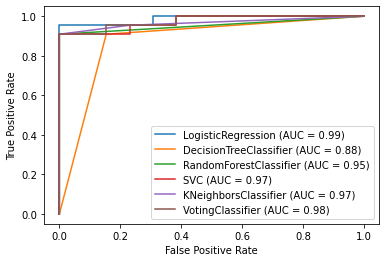

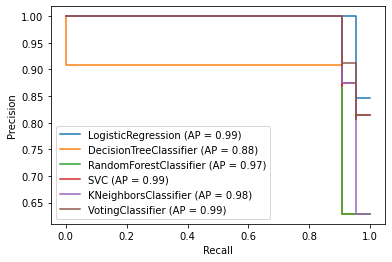

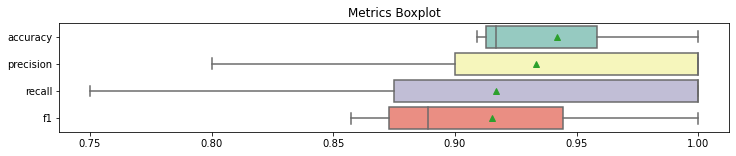

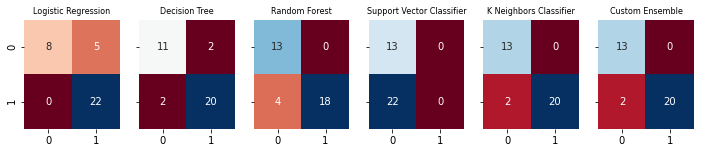

In [24]:
# train and evaluate models using the 2 components from PCA
trained_models_using_pca_comp = train.train_models(pca_train_x, smote_train_y, smote_test_x, smote_test_y)
evaluate.generate_metrics(trained_models_using_pca_comp, pca_test_x, pca_test_y, 
                          ['accuracy', 'precision', 'recall', 'f1'], cv_num=cross_val_num, show_raw_data=False)

In [25]:
# apply dimensionality reduction using LDA

# creating two components separately due to the know restriction n_components cannot be larger than min(n_features, n_classes - 1)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=1)

# print(smote_x.iloc[:, [0,1,2,3]])
# education  avg_gr_time_in_gs  family_med_history  total_gr_in_gs
# Selecting (avg_gr_time_in_gs, family_med_history) and (education, total_gr_in_gs) based on Spearman correlation coefficient

# print('lda_x_one from:',smote_x.iloc[:, [0,3]].shape)
lda_x_one = lda.fit_transform(smote_x.iloc[:, [0,3]], smote_y)
# print('lda_x_one:', lda_x_one.shape)

# print('lda_x_two from:',smote_x.iloc[:, [1,2]].shape)
lda_x_two = lda.fit_transform(smote_x.iloc[:, [1,2]], smote_y)
# print('lda_x_two:', lda_x_two.shape)

lda_x = np.concatenate((lda_x_one, lda_x_two),axis=1)
# print('lda_x:',lda_x.shape)

plt.figure()
colors = ['red', 'blue']
lw = 2
for color, i, target_name in zip(colors, [1, 2], ['AD-MCI','NC']):
    plt.scatter(lda_x[smote_y == i, 0], lda_x[smote_y == i, 1], color=color, alpha=.8, lw=lw, label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of data set')
plt.show();

NameError: name 'np' is not defined

In [ ]:
# split of pca_x and smote_y to train test data set
lda_train_x, lda_test_x, lda_train_y, lda_test_y = train_test_split(lda_x, smote_y, random_state=7, test_size=test_size)

In [ ]:
# train and evaluate models using the 2 components from LDA
trained_models_using_lda = train.train_models(lda_train_x, smote_train_y, smote_test_x, smote_test_y)
evaluate.generate_metrics(trained_models_using_lda, lda_test_x, lda_test_y, 
                          ['accuracy', 'precision', 'recall', 'f1'], cv_num=cross_val_num, show_raw_data=False)